In [1]:
#import data

# -*- coding: utf-8 -*-

#import data
import pandas as pd
import numpy as np
import torch.onnx
import os
from time import time

import torch
import torch.nn as nn
# import torch.nn.functional as F
import matplotlib.pyplot as plt
import re


In [2]:
all_x_data = []
all_y_data = []

file_path = os.path.join("..","dataset","traindata","train_var_mu.csv")
file_path = os.path.abspath(file_path)
# print("===trin data file path===", "\n", file_path)

# Pandas를 이용해 파일 읽기
data = pd.read_csv(file_path, sep=",", header=0, dtype=float)
x_data = torch.tensor(data.iloc[:, [0,2,3,4,5]].values, dtype=torch.float32)
y_data = torch.tensor(data.iloc[:, 1:2].values, dtype=torch.float32)

# 전체 데이터 리스트에 추가
all_x_data.append(x_data)
all_y_data.append(y_data)
        
# 리스트에 저장된 모든 데이터를 하나의 텐서로 결합
all_x_data = torch.cat(all_x_data, dim=0)
all_y_data = torch.cat(all_y_data, dim=0)

# 전체 데이터에 대한 평균과 분산 계산
mean_x = torch.mean(all_x_data, dim=0)
std_x = torch.std(all_x_data, dim=0)

Max_Vy = max(abs(all_y_data))

In [3]:
#학습된 신경망 불러오기
model_directory = os.path.join("model")
model_directory = os.path.abspath(model_directory)
pt_files = [ os.path.join(model_directory,f) for f in os.listdir(model_directory) if f.endswith('.pt')]

LSTM_16_16_16_model_1
tensor([[[ 0.8855, -0.1161, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8853, -0.2232, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8851, -0.2248, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8849, -0.2247, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8847, -0.2244, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8845, -0.2240, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8843, -0.2236, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8841, -0.2232, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8839, -0.2228, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8837, -0.2224, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8835, -0.2220, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8833, -0.2216, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8831, -0.2213, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8829, -0.2210, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8827, -0.2207, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8825, -0.2204, -0.0624, -0.0612, -0.0377]]])
tensor([[[ 0.8823, -0.2202, -0.0624, -0.0612, -0.0

KeyboardInterrupt: 

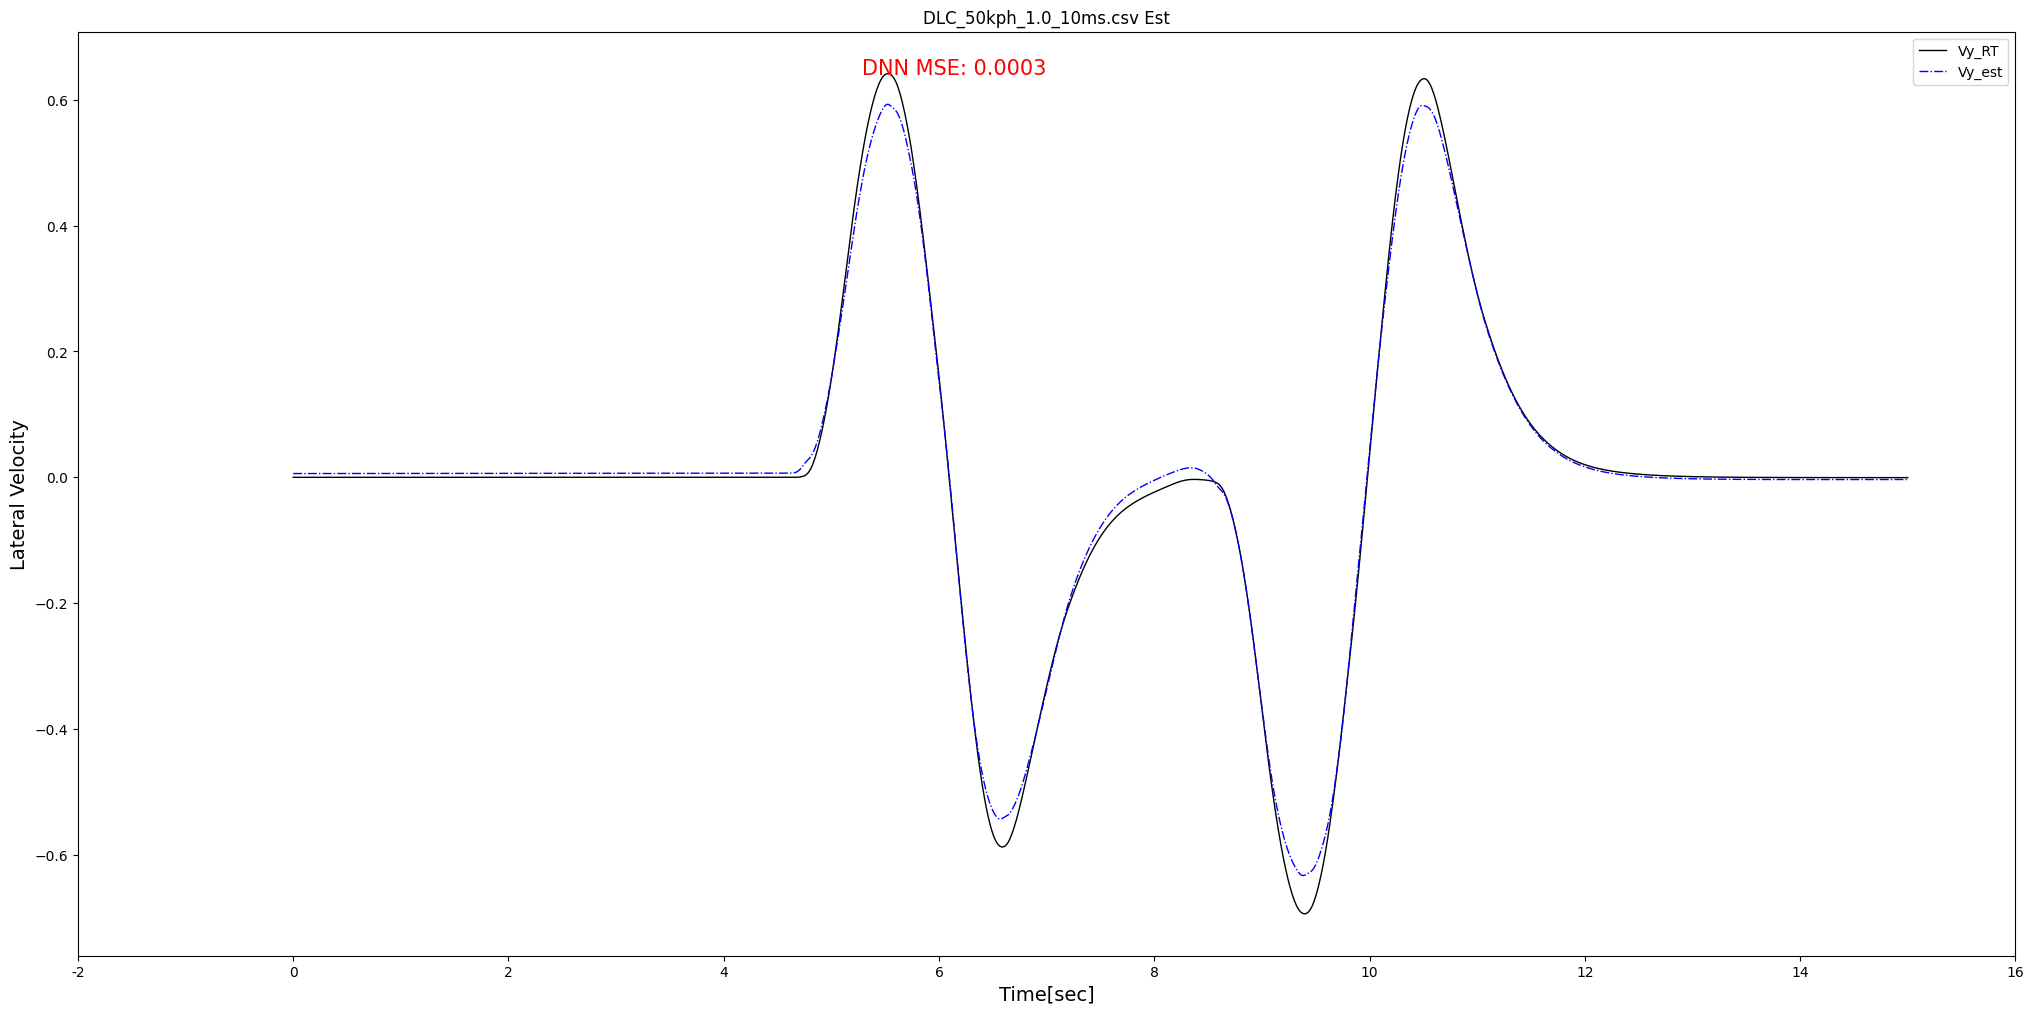

In [4]:
csv_data = [["model name", "Total number of predictions", "min Prediction time", "max Prediction time", "average Prediction time", "Percentage of predicted time longer than QoS"]]
mse_list = []

for model_path in pt_files:
    model = torch.jit.load(model_path)

    model.eval()  # 모델을 평가 모드로 설정
    model_name = model_path.split("\\")[-1][:-3]
    print(model_name)

    Prediction_time_list = []

    test_directory_path = os.path.join("..", "dataset","testdata")
    test_directory_path = os.path.abspath(test_directory_path)
    # print("===test directory path===", "\n", test_directory_path)

    figure_save_path = os.path.join("results",model_name)
    figure_save_path = os.path.abspath(figure_save_path)
    # print("===figure path===", "\n", figure_save_path)

    if not os.path.exists(figure_save_path):
        os.makedirs(figure_save_path)

    for filename in os.listdir(test_directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(test_directory_path, filename)
            
            test_data = pd.read_csv(file_path, sep=",", header=0, dtype=float)
            test_x_data = torch.tensor(test_data.iloc[:, [0,2,3,4,5]].values, dtype=torch.float32)
            test_y_data = torch.tensor(test_data.iloc[:, 1:2].values, dtype=torch.float32)
            test_x_data_normalized = (test_x_data - mean_x) / std_x  # mean과 std는 훈련 데이터셋에서 계산된 값 사용
            
            predictions_list = []
            
            with torch.no_grad():  # 그래디언트 계산 비활성화
                for i in range(len(test_x_data)):
                    # 현재 스텝의 테스트 데이터
                    current_test_data = test_x_data_normalized[i].unsqueeze(0).unsqueeze(0)  # (1, 1, input_size) 형식으로 변환
                    print(current_test_data)
                    # 모델을 통해 예측 수행
                    start_time = time()
                    current_prediction = model(current_test_data)
                    Prediction_time_list.append(time()- start_time)
                    
                    real_prediction = current_prediction * Max_Vy
                    
                    # 예측값 저장
                    predictions_list.append(real_prediction.item())
        
            # 모든 스텝에 대한 예측값을 텐서로 변환
            predictions = torch.tensor(predictions_list).unsqueeze(1)
            mse1 = np.mean((test_y_data.numpy() - predictions.numpy())**2)
            mse_list.append(mse1)

            plt.figure(figsize=(25, 12))
            
            #첫 번째 plot
            # plt.subplot(4, 1, 1)
            plt.plot(test_y_data.numpy(), label='Vy_RT', color='black', linestyle='-', linewidth=1)
            plt.plot(predictions.numpy(), label='Vy_est', color='blue', linestyle='-.', linewidth=1)
            # MSE를 레이블로 표시
            plt.text(0.5, 0.95, f'DNN MSE: {mse1:.4f}',
                    verticalalignment='bottom', horizontalalignment='right',
                    transform=plt.gca().transAxes,
                    color='red', fontsize=15)
            plt.legend()
            plt.title(f'{filename} Est')
            plt.xlabel('Time[sec]', fontsize=14, color='black')
            plt.ylabel('Lateral Velocity', fontsize=14, color='black')
            
            # 현재 X 축 눈금 위치를 가져옵니다.
            current_xticks = plt.xticks()[0]
            
            # X 축 레이블을 설정합니다. 레이블은 현재 눈금 위치를 100으로 나눈 값입니다.
            plt.xticks(current_xticks, [f'{x/100:.0f}' for x in current_xticks])
            
            
            plt.gca().tick_params(axis='x', colors='black')  # x축 눈금 레이블 색상 변경
            plt.gca().tick_params(axis='y', colors='black')  # y축 눈금 레이블 색상 변경

            result_filename = filename.replace(".csv", ".png")
            save_path = os.path.join(figure_save_path, result_filename)
            plt.savefig(save_path)
            plt.close()
            # 정규 표현식을 사용하여 'scenario' 뒤의 숫자 추출
            match = re.search(r'scenario(\d+)', filename)
            if match:
                scenario_number = match.group(1)  # 'scenario' 뒤의 숫자 부분
                new_filename = f'predictions_scenario{scenario_number}.csv'  # 새 파일 이름 생성
                predictions_txt_path = os.path.join(figure_save_path, new_filename)
                with open(predictions_txt_path, 'w') as f:
                    for prediction in predictions_list:
                        f.write(f"{prediction}\n")

    # QoS = 0.000109 sec
    print(rf"Total number of predictions : {len(Prediction_time_list)}")
    print(rf"min Prediction time : {round(min(Prediction_time_list),6)}")
    print(rf"max Prediction time : {round(max(Prediction_time_list),6)}")
    print(rf"average Prediction time : {round(sum(Prediction_time_list)/len(Prediction_time_list),6)}")

    QoS = 0.000109
    longer_than_QoS_count = 0
    for T in Prediction_time_list:
        if(T > QoS): longer_than_QoS_count += 1

    print(rf"Percentage of predicted time longer than QoS: {round(longer_than_QoS_count/len(Prediction_time_list)*100,2)}%")
    print("\n")
    
    csv_data.append([model_name,
                     len(Prediction_time_list),
                     round(min(Prediction_time_list),6),
                     round(max(Prediction_time_list),6),
                     round(sum(Prediction_time_list)/len(Prediction_time_list),6),
                     round(longer_than_QoS_count/len(Prediction_time_list)*100,2),
                     round(sum(mse_list)/len(mse_list),6)])

In [ ]:
import csv
csv_file_path = os.path.join("LSTM_validation_results.csv")

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)